## Next Steps 

* decide on normalization method 
* create CNN without transfer learning
* use ImageAug to transform images, retrain CNN without transfer learning
* create CNN with transfer learning 

In [1]:
# !pip install --upgrade imgaug

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import h5py
from skimage.transform import resize



In [3]:
train_path = '../input/food41/food_c101_n1000_r384x384x3.h5'
test_path = '../input/food41/food_test_c101_n1000_r128x128x3.h5'


In [4]:
#opening training data 

f = h5py.File(train_path, "r")
f.keys()
train_images = f['images'][...]
train_category = f['category'][...]
train_category_names = f['category_names'][...]
f.close()

In [5]:
#opening testing data 

f = h5py.File(test_path, "r")
f.keys()
test_images = f['images'][...]
test_category = f['category'][...]
test_category_names = f['category_names'][...]
f.close()

In [6]:
print('Shape of train_category: ', train_category.shape)
print('Shape of train_images: ', train_images.shape)


print('Shape of test_category: ', test_category.shape)
print('Shape of test_images: ', test_images.shape)

Shape of train_category:  (1000, 101)
Shape of train_images:  (1000, 384, 384, 3)
Shape of test_category:  (1000, 101)
Shape of test_images:  (1000, 128, 128, 3)


In [7]:
# resized  images to 224 x 224 x 3 for transfer learning later on

train_resized = np.zeros((1000,224,224,3))

for n,i in enumerate(train_images):
    train_resized[n,:,:,:] = resize(train_images[n,:,:,:], train_resized.shape[1:], anti_aliasing=True)

print(train_resized.shape)


(1000, 224, 224, 3)


In [8]:
test_resized = np.zeros((1000,224,224,3))

for n,i in enumerate(test_images):
    test_resized[n,:,:,:] = resize(test_images[n,:,:,:], test_resized.shape[1:], anti_aliasing=True)

print(test_resized.shape)


(1000, 224, 224, 3)


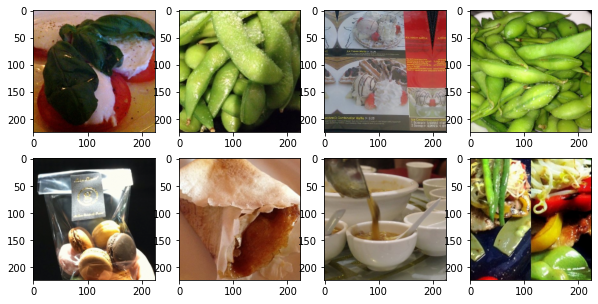

In [9]:
# checking to see the images rescaled successfully 
plt.subplots(2,4,figsize = (10,5))

for i in range(8):
    img_np = train_resized[i]
    plt.subplot(2,4,1+i)
    plt.imshow(img_np)
plt.show()

In [10]:
# creating validation split from training data 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_resized, train_category, test_size = 0.2, random_state = 42) 

In [11]:
# converting pixel values to float type
# mean subtraction centers the cloud of data around the origin along every dimension (think of all data points plotted on a graph, this will move the data cluster to have the center as 0,0)
# normalizing by dividing by training std. This is so the data dimensions are approximately the same scale, and makes model processing faster

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = test_resized.astype('float32')

mean_training = np.mean(X_train)
print('training mean is :', mean_training)
std_training = np.std(X_train)
print('training std is :', std_training)

X_train -= mean_training
X_val -= mean_training
X_test -= mean_training

X_train /= std_training
X_val /= std_training
X_test /= std_training

training mean is : 0.43474594
training std is : 0.27792257


In [12]:
#changing name of test category (what we're looking to predict)
y_test = test_category

In [13]:
print('X_train shape:',X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)


X_train shape: (800, 224, 224, 3)
X_val shape: (200, 224, 224, 3)
X_test shape: (1000, 224, 224, 3)


In [14]:
print('y_train shape:',y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test:', y_test.shape)

y_train shape: (800, 101)
y_val shape: (200, 101)
y_test: (1000, 101)


In [15]:
# changing from 'true/false' values to 0/1 binary values 
y_train = y_train*1
y_val = y_val *1
y_test = y_test *1

## CNN model without transformations or transfer learning 

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


In [17]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size =(3,3), activation = 'relu', input_shape = (224, 224, 3), padding = 'same'))
model1.add(MaxPooling2D(pool_size = (3,3)))

model1.add(Conv2D(64, kernel_size= (3,3), activation = 'relu', padding = 'same'))#how do we determine filter numbers
model1.add(MaxPooling2D(pool_size = (3,3)))

model1.add(Conv2D(128, kernel_size= (3,3), activation = 'relu', padding = 'same'))
model1.add(Flatten())

model1.add(Dense(128, activation = 'relu'))#should we do randomsearch or GridSearch for units/layer
model1.add(Dense(101, activation = 'softmax'))

model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9

In [18]:
# choosing to monitor val_loss instead of val_accuracy because val_loss measures how confident we are in the prediction. Even if we predict accurately, but are under 50% confident, it is not a good model
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 5)

In [19]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, batch_size = 32, callbacks = (early_stopping_monitor))

Epoch 1/20
25/25 [==============================] - 8s 113ms/step - loss: 4.7881 - accuracy: 0.0133 - val_loss: 4.6188 - val_accuracy: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 2s 81ms/step - loss: 4.6014 - accuracy: 0.0129 - val_loss: 4.6093 - val_accuracy: 0.0200
Epoch 3/20
25/25 [==============================] - 2s 81ms/step - loss: 4.5421 - accuracy: 0.0279 - val_loss: 4.7167 - val_accuracy: 0.0050
Epoch 4/20
25/25 [==============================] - 2s 82ms/step - loss: 4.3384 - accuracy: 0.0768 - val_loss: 4.8529 - val_accuracy: 0.0050
Epoch 5/20
25/25 [==============================] - 2s 83ms/step - loss: 3.7096 - accuracy: 0.1800 - val_loss: 5.5045 - val_accuracy: 0.0400
Epoch 6/20
25/25 [==============================] - 2s 83ms/step - loss: 2.3038 - accuracy: 0.4363 - val_loss: 6.5995 - val_accuracy: 0.0150
Epoch 7/20
25/25 [==============================] - 2s 82ms/step - loss: 1.0213 - accuracy: 0.7632 - val_loss: 8.0275 - val_accuracy: 0.0200


In [20]:
_,acc = model1.evaluate(X_val, y_val)
print(acc * 100)

7/7 [==============================] - 0s 48ms/step - loss: 4.6093 - accuracy: 0.0200
1.9999999552965164


In [21]:
model1.save("model1.hdf5")

In [22]:
y_pred1 = model1.predict(X_test)

In [23]:
print('y_test shape:',y_test.shape)
print('y_pred shape:', y_pred1.shape)

y_test shape: (1000, 101)
y_pred shape: (1000, 101)


In [24]:
# the shape of y_test and y_pred are not in the correct format for the sklearn's classification_report, needed to vectorize  
y_test = np.argmax(y_test, axis=1)
y_pred1 = np.argmax(y_pred1, axis=1)

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred1, target_names = test_category_names))

                         precision    recall  f1-score   support

           b'apple_pie'       0.00      0.00      0.00         8
      b'baby_back_ribs'       0.00      0.00      0.00        10
             b'baklava'       0.00      0.00      0.00        11
      b'beef_carpaccio'       0.00      0.00      0.00        14
        b'beef_tartare'       0.00      0.00      0.00        10
          b'beet_salad'       0.00      0.00      0.00        20
            b'beignets'       0.00      0.00      0.00        11
            b'bibimbap'       0.00      0.00      0.00         7
       b'bread_pudding'       0.00      0.00      0.00        11
   b'breakfast_burrito'       0.00      0.00      0.00         4
          b'bruschetta'       0.00      0.00      0.00         7
        b'caesar_salad'       0.00      0.00      0.00         9
             b'cannoli'       0.00      0.08      0.01        12
       b'caprese_salad'       0.00      0.00      0.00         9
         b'carrot_cake' 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transfer learning with VGG16

In [26]:
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [27]:
checkpointer = ModelCheckpoint(filepath='modelvgg16.hdf5',monitor = 'val_loss', verbose=1,save_best_only=True)

modelvgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

modelvgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [28]:
# Freeze four convolution blocks
for layer in modelvgg16.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(modelvgg16.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [29]:
modelvgg16_full = Sequential()
modelvgg16_full.add(modelvgg16)
modelvgg16_full.add(Flatten())
modelvgg16_full.add(Dense(512, activation='relu'))
modelvgg16_full.add(Dropout(0.2))
modelvgg16_full.add(Dense(256, activation = 'relu'))
modelvgg16_full.add(Dense(101, activation='softmax'))
modelvgg16_full.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 101)               25957     
Total params: 27,717,541
Trainable params: 20,082,277
Non-trainable params: 7,635,264
__________________________________

In [30]:
opt = Adam(lr=0.00001)
modelvgg16_full.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = modelvgg16_full.fit(X_train, y_train, batch_size=32, epochs=50,
          validation_data=(X_val, y_val), callbacks=[checkpointer, early_stopping_monitor],verbose=1, shuffle = True)


Epoch 1/50
25/25 [==============================] - 130s 5s/step - loss: 4.8137 - accuracy: 0.0086 - val_loss: 4.7007 - val_accuracy: 0.0100

Epoch 00001: val_loss improved from inf to 4.70066, saving model to modelvgg16.hdf5
Epoch 2/50
25/25 [==============================] - 108s 4s/step - loss: 4.4999 - accuracy: 0.0412 - val_loss: 4.6754 - val_accuracy: 0.0100

Epoch 00002: val_loss improved from 4.70066 to 4.67544, saving model to modelvgg16.hdf5
Epoch 3/50
25/25 [==============================] - 108s 4s/step - loss: 4.2945 - accuracy: 0.0941 - val_loss: 4.6646 - val_accuracy: 0.0150

Epoch 00003: val_loss improved from 4.67544 to 4.66459, saving model to modelvgg16.hdf5
Epoch 4/50
25/25 [==============================] - 108s 4s/step - loss: 4.0248 - accuracy: 0.1774 - val_loss: 4.6709 - val_accuracy: 0.0200

Epoch 00004: val_loss did not improve from 4.66459
Epoch 5/50
25/25 [==============================] - 108s 4s/step - loss: 3.6654 - accuracy: 0.2756 - val_loss: 4.6781 - v

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

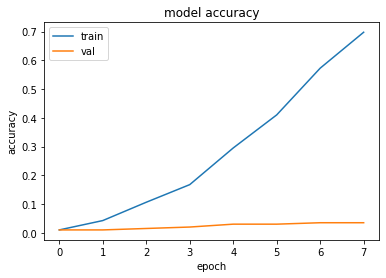

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

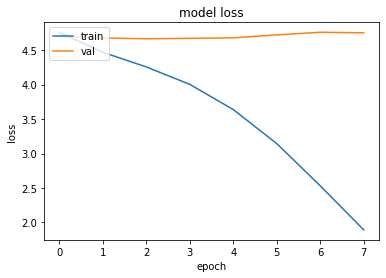

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Since the val_loss has stopped decreasing, but val_accuracy is continuing to improve, this might be a sign of overfitting. The model is starting to learn the training data too well. The options now would be to regularlize more, or to find new images or augmented/transformed images to train on. 

For this scenario, I think we do not have a large enough of training data, specific to the classes. Let's try to use image augmentation to see if it'll help. 


## Transfer learning with VGG16 and Augmented Images

In [34]:
#Augment images
train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)

#Fit augmentation to training images
train_generator = train_datagen.flow(X_train,y_train,batch_size=1)

In [35]:
history = modelvgg16_full.fit(train_generator, validation_data=(X_val,y_val), epochs=50, shuffle=True, callbacks=[checkpointer, early_stopping_monitor],verbose=1)

Epoch 1/50
800/800 [==============================] - 120s 148ms/step - loss: 4.5854 - accuracy: 0.0225 - val_loss: 4.5678 - val_accuracy: 0.0350

Epoch 00001: val_loss improved from 4.66459 to 4.56776, saving model to modelvgg16.hdf5
Epoch 2/50
800/800 [==============================] - 118s 148ms/step - loss: 4.3533 - accuracy: 0.0562 - val_loss: 4.5190 - val_accuracy: 0.0500

Epoch 00002: val_loss improved from 4.56776 to 4.51897, saving model to modelvgg16.hdf5
Epoch 3/50
800/800 [==============================] - 118s 148ms/step - loss: 4.0684 - accuracy: 0.1150 - val_loss: 4.3757 - val_accuracy: 0.0600

Epoch 00003: val_loss improved from 4.51897 to 4.37567, saving model to modelvgg16.hdf5
Epoch 4/50
800/800 [==============================] - 118s 148ms/step - loss: 3.6201 - accuracy: 0.1950 - val_loss: 4.2888 - val_accuracy: 0.1050

Epoch 00004: val_loss improved from 4.37567 to 4.28880, saving model to modelvgg16.hdf5
Epoch 5/50
800/800 [==============================] - 118s 1

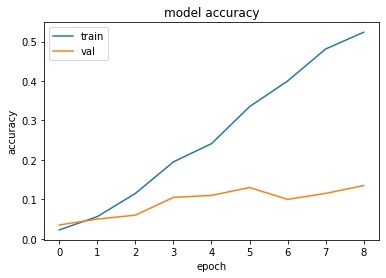

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

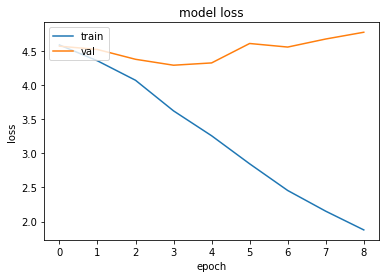

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

bounding boxes and more intial data (1000 per class, or 100,000 images. 